# Case study: Regular exercise suppresses steatosis-associated liver cancer development by degrading E2F1 and c-Myc via circadian gene upregulation

## Theodoro Gasperin Terra Camargo (r0974221)

**Research question:** How does regular exercise suppress liver cancer development at the molecular level in mice?

**Experiment setup:** 

* Exercise group:
    * tumor tissue
    * non-tumor tissue
    
* Non-Exercise group:
    * tumor tissue (positive control)
    * non-tumor tissue (negative control)
    
**Comparisom of interest:** 

* Exercise (Non-Tumor) vs. Non-Exercise (Non-Tumor) --> genes affected by exercise on healthy tissue
* Exercise (Tumor) vs. Non-Exercise (Tumor) -------------> genes affected by exercise on cancer tissue
    
**Note**:

All processed data can be found here:

https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA1142455&o=acc_s%3Aa

Paper can be found here: 

https://onlinelibrary.wiley.com/doi/full/10.1111/gtc.13161

Here we will use DESeq2 to perform differential gene expression analysis. DESeq2 has a nice tutorial that can be found [here](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html).

## Step 0. set up working directory

In [1]:
USER <- Sys.getenv("USER")
setwd(paste0("/mnt/storage/",USER,"/jupyternotebooks//assignment_1/bulk_RNA_seq"))

## Step 1. Load data

The starting point of a DESeq2 analysis is a count matrix K with one row for each gene i and one column for each sample j. The matrix entries K ij indicate the number of sequencing reads that have been unambiguously mapped to a gene in a sample. Let's load the count matrix we generated in the previous notebook.

In [2]:
cts <- as.matrix(read.csv("counts/samples.counts.formatted", sep="\t", row.names = "Geneid"))

In [3]:
head(cts, 5)

,exe_non_tumor_1,exe_non_tumor_2,exe_tumor_1,exe_tumor_2,non_exe_non_tumor_1,non_exe_non_tumor_2,non_exe_tumor_1,non_exe_tumor_2
4933401J01Rik,0,0,0,0,0,0,0,0
Gm26206,0,0,0,0,0,0,0,0
Xkr4,1,0,0,0,0,0,0,1
Gm18956,0,0,0,0,0,0,0,0
Gm37180,0,0,0,0,0,0,0,0


Next we will generate a dataframe containing metadata on our samples.

In [4]:
coldata <- data.frame(
    row.names = c("exe_non_tumor_1", "exe_non_tumor_2", "exe_tumor_1", "exe_tumor_2", "non_exe_non_tumor_1", "non_exe_non_tumor_2", "non_exe_tumor_1", "non_exe_tumor_2"),
    condition = c("treatment_healthy", "treatment_healthy", "treatment_tumor", "treatment_tumor", "control_negative", "control_negative", "control_positive", "control_positive") 
)

In [5]:
coldata

,condition
,<fct>
exe_non_tumor_1,treatment_healthy
exe_non_tumor_2,treatment_healthy
exe_tumor_1,treatment_tumor
exe_tumor_2,treatment_tumor
non_exe_non_tumor_1,control_negative
non_exe_non_tumor_2,control_negative
non_exe_tumor_1,control_positive
non_exe_tumor_2,control_positive


**It's critical that the columns of the count matrix and the rows of the coldata are in the same order**. This is the case here.

In [6]:
all(rownames(coldata) == colnames(cts))

[1] TRUE

Next we construct the DESeqDataSet. For this we need:
- the count matrix (cts)
- the metadata (coldata)
- the design, this specifies which variables to use to perform differential gene expression testing. In our case this variable is stored in the "condition" column of the metadata dataframe, as we want to test for differential expression between treatment and control.

In [8]:
suppressWarnings(library("DESeq2"))
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ condition)
dds

class: DESeqDataSet 
dim: 52535 8 
metadata(1): version
assays(1): counts
rownames(52535): 4933401J01Rik Gm26206 ... Vmn2r122 CAAA01147332.1
rowData names(0):
colnames(8): exe_non_tumor_1 exe_non_tumor_2 ... non_exe_tumor_1
  non_exe_tumor_2
colData names(1): condition

In [9]:
dds$condition

[1] treatment_healthy treatment_healthy treatment_tumor   treatment_tumor  
[5] control_negative  control_negative  control_positive  control_positive 
4 Levels: control_negative control_positive ... treatment_tumor

Let's set the order of the treatment and control group. Our control group is the baseline, so we set this as the first level.

In [10]:
dds$condition <- factor(dds$condition, levels = c("control_positive", "control_negative", "treatment_healthy", "treatment_tumor"))

We will perform some prefiltering to only keep genes that have a count of at least 10 for a minimum of 2 samples

In [11]:
smallestGroupSize <- 2
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]

## Step 2. Model read counts and performing differential expression analysis

Given the count matrix: $K_{ij}$ with one row for each gene $i$ and one columns for each sample $j$

Read counts $K_{ij}$ are modeled as a negative binomial distribution (a.k.a. gamma-Poisson distribution) with a fitted mean $\mu_{ij}$ and gene specific dispersion $\alpha_{i}$. 

<p style="text-align: center;">$K_{ij} \sim \text{NB}(\mu_{ij}, \alpha_{i})$</p>

For illustrative purposes, the distribution of the expression of genes in sample MCF7_NS1 is shown.

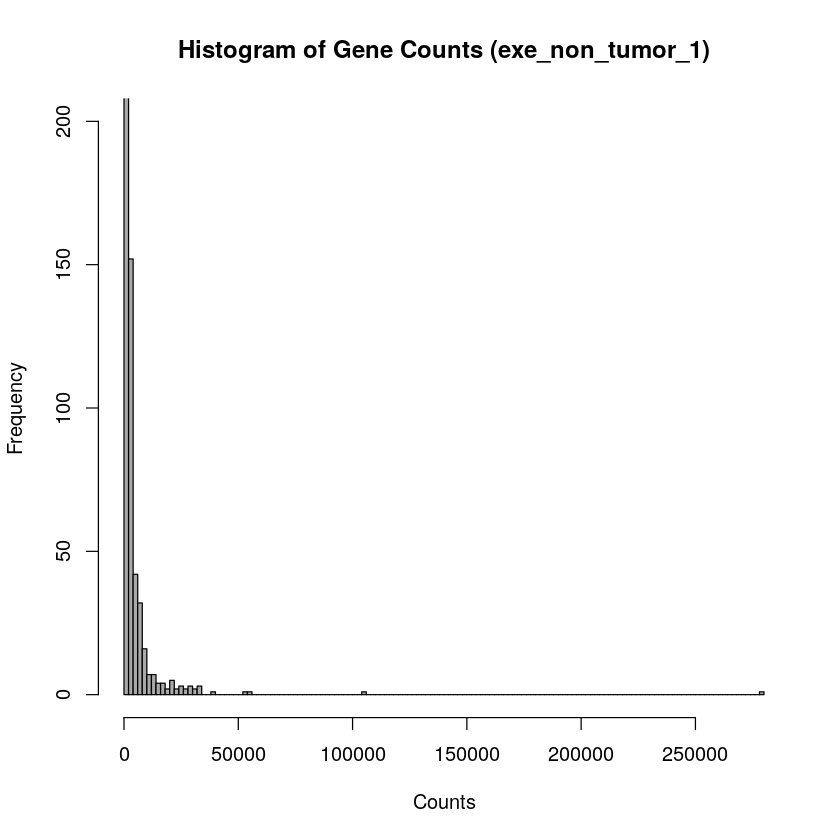

In [12]:
hist(cts[, 'exe_non_tumor_1'], 
     breaks = 100, 
     ylim = c(0, 200), 
     col = "darkgray", 
     main = "Histogram of Gene Counts (exe_non_tumor_1)", 
     xlab = "Counts")

The fitted mean $\mu_{ij}$ is composed of sample-specific size factor $s_j$ and a parameter $q_{ij}$, proportional to the concentration of cDNA fragments from the gene $i$ in sample $j$.

<p style="text-align: center;">$\mu_{ij}=s_j \cdot q_{ij}$</p>

The parameter $s_j$, which is the same for all genes in a sample, accounts for differences in sequencing depths between two samples. It can also be advantageous to calculate a gene-specific normalization factor $s_{ij}$. This gene- and sample-specific normalization factor accounts for further sources of technical bias such as differing dependence on GC content, gene length, ...

In this case the formula looks like this:

<p style="text-align: center;">$\mu_{ij}=s_{ij} \cdot q_{ij}$</p>

Finally generalized linear models (GLMs) are used to fit for each gene as follows:

<p style="text-align: center;">$\log_2{q_{ij}} = \sum_r{x_{jr} \cdot \beta_{ir} }$</p>

With $x_{jr}$ a design matrix for $r$ conditions indicating wether sample $j$ belongs to each condition $r$ or not.

In this case we have only a single condition (control vs treatment) and thus the formula simplifies to:

<p style="text-align: center;">$\log_2{q_{ij}} = x_{j} \cdot \beta_{i} $</p>

$\beta_{i}$ gives the log2 fold change for gene $i$.

The variability between replicates is modeled using the dispersion parameter $\alpha_{i}$. It defines the relationship between the variance of the observed count and its mean value (how far do we expected the observed count will be from the mean value).

<p style="text-align: center;">$\text{Var}(K_{ij}) = E[(K_{ij} - \mu_{ij})^2] = \mu_{ij} + \alpha_i \cdot \mu_{ij}^2$
    
Accurate estimation of this dispersion parameter $\alpha_i$ is critical for statistical testing of differential expression. For studies with a small sample size this parameter is difficult to estimate. DESeq2 solves this issue by assuming that genes with similar average expression values will have a similar dispersion. 


Warning message:
“Transformation introduced infinite values in continuous y-axis”


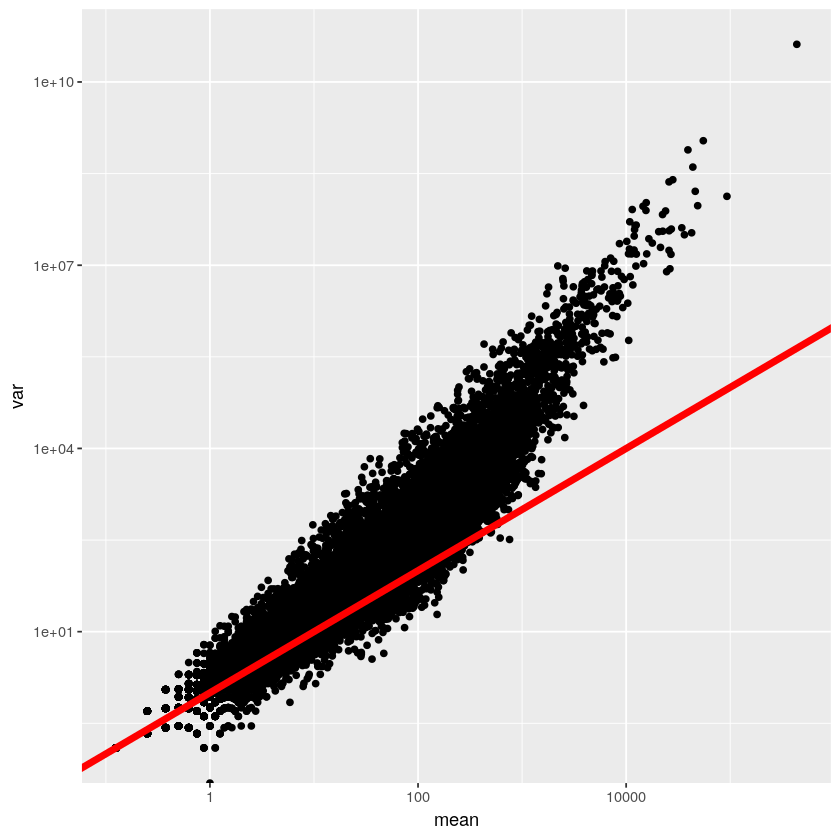

In [13]:
library(ggplot2)
data <- data.frame(
    mean = rowMeans(cts[rowSums(cts) != 0, ]),
    var  = rowVars(cts[rowSums(cts) != 0, ]))
ggplot(data, aes(x = mean, y = var)) +
    geom_point() +
    scale_x_continuous(trans = "log10") +
    scale_y_continuous(trans = "log10") +
    geom_abline(intercept = 0, slope = 1, color = "red", linewidth = 2)

The Red line represents the case where the variance equals the mean

The **size factors** $s_{j}$ can be estimated for each sample using the function
    
        estimateSizeFactors

In [14]:
dds <- estimateSizeFactors(dds)

In [15]:
dds@colData

DataFrame with 8 rows and 2 columns
                            condition        sizeFactor
                             <factor>         <numeric>
exe_non_tumor_1     treatment_healthy 0.953122385959589
exe_non_tumor_2     treatment_healthy  1.03559131651497
exe_tumor_1           treatment_tumor  1.04349705962056
exe_tumor_2           treatment_tumor 0.917204492527578
non_exe_non_tumor_1  control_negative   1.0677314724089
non_exe_non_tumor_2  control_negative  1.06286945144787
non_exe_tumor_1      control_positive  1.09178744945346
non_exe_tumor_2      control_positive 0.900323089123961

The **dispersion** $\alpha_{i}$ can be estimated using the function

    estimateDispersions

In [16]:
dds <- estimateDispersions(dds)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [17]:
head(mcols(dds))

DataFrame with 6 rows and 10 columns
                baseMean          baseVar   allZero         dispGeneEst
               <numeric>        <numeric> <logical>           <numeric>
Sox17   17.9218351322995 50.3839085683411     FALSE               1e-08
Mrpl15  196.706977153318 917.729719825286     FALSE               1e-08
Lypla1  663.927686987207 21182.3382308834     FALSE 0.00528141338705306
Tcea1    89.189070084373 160.925931394375     FALSE               1e-08
Atp6v1h 301.397408016249 991.640205679338     FALSE               1e-08
Rb1cc1  236.936023938396 418.974036771949     FALSE               1e-08
        dispGeneIter            dispFit         dispersion  dispIter
           <numeric>          <numeric>          <numeric> <integer>
Sox17              1   0.25653409314945  0.158204232139359        10
Mrpl15             1 0.0551601251796703 0.0245999685070362         8
Lypla1             4 0.0409546525826628 0.0214614377575149        10
Tcea1             21 0.0794946879624947 0.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


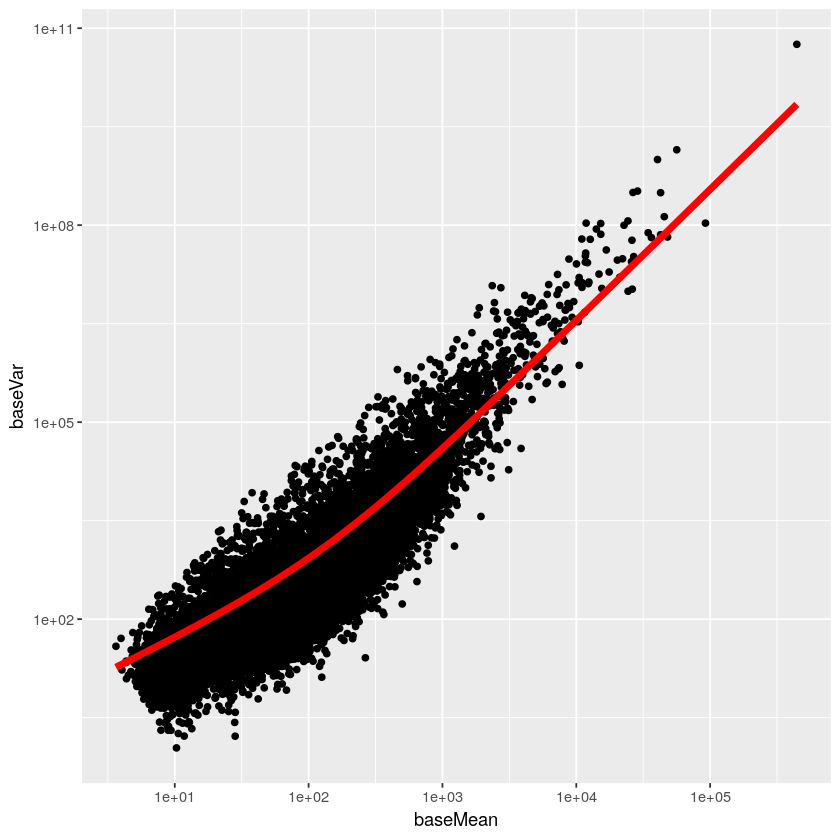

In [18]:
ggplot(as.data.frame(mcols(dds)[!mcols(dds)$allZero, ])) +
    geom_point(aes(x = baseMean, y = baseVar )) + 
    geom_line(aes(x = baseMean, y = baseMean + dispFit * baseMean * baseMean ), color = "red", size = 2) +
    scale_x_continuous(trans = "log10") +
    scale_y_continuous(trans = "log10")

As you can see the red line now fits the data much better!

Finally we can **fit the GLM for each gene** to obtain $\beta_j$, the log2FC of each gene across the two conditions. using the function:

    nbinomWaldTest
    


In [19]:
dds <- nbinomWaldTest(dds)

The results of this can be visualized using the function

    results

In [20]:
res <- results(dds)
res

log2 fold change (MLE): condition treatment tumor vs control positive 
Wald test p-value: condition treatment tumor vs control positive 
DataFrame with 12353 rows and 6 columns
                baseMean      log2FoldChange             lfcSE
               <numeric>           <numeric>         <numeric>
Sox17   17.9218351322995 -0.0794216920914691 0.649606839573883
Mrpl15  196.706977153318   0.284394304325251 0.250585274026352
Lypla1  663.927686987207   0.167465087152401 0.220380413533304
Tcea1    89.189070084373  -0.135436026441132 0.349670698859575
Atp6v1h 301.397408016249   0.165697891217152   0.2329475973178
...                  ...                 ...               ...
mt-Nd4   17595.333834649   0.445484169674027 0.234692315752029
mt-Nd5  21122.2012989453   0.527916733380464 0.251392191758735
mt-Nd6  7239.17946086626   0.587413169536305 0.260319222916912
mt-Cytb 45442.2545225807   0.523744642817081 0.268426077946706
mt-Tp   16.2642361249761 -0.0185602109955696 0.734789980209894
    

The three functions above:

    estimateSizeFactors
    estimateDispersions
    nbinomWaldTest
   
can be run in one go using the wrapper function:

    DESeq

In [21]:
dds <- DESeq(dds)
res <- results(dds)
res

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition treatment tumor vs control positive 
Wald test p-value: condition treatment tumor vs control positive 
DataFrame with 12353 rows and 6 columns
                baseMean      log2FoldChange             lfcSE
               <numeric>           <numeric>         <numeric>
Sox17   17.9218351322995 -0.0794216920914691 0.649606839573883
Mrpl15  196.706977153318   0.284394304325251 0.250585274026352
Lypla1  663.927686987207   0.167465087152401 0.220380413533304
Tcea1    89.189070084373  -0.135436026441132 0.349670698859575
Atp6v1h 301.397408016249   0.165697891217152   0.2329475973178
...                  ...                 ...               ...
mt-Nd4   17595.333834649   0.445484169674027 0.234692315752029
mt-Nd5  21122.2012989453   0.527916733380464 0.251392191758735
mt-Nd6  7239.17946086626   0.587413169536305 0.260319222916912
mt-Cytb 45442.2545225807   0.523744642817081 0.268426077946706
mt-Tp   16.2642361249761 -0.0185602109955696 0.734789980209894
    

Genes with a low read count have a strong variance of the Log2FolcChange (see plot below). Because of this, weakly expressed genes can seem to have strong differences between two conditions. However, this is not due to a real difference but due to noise in the measurements. This will cause issues if we want to rank genes based on their log2fold change values.

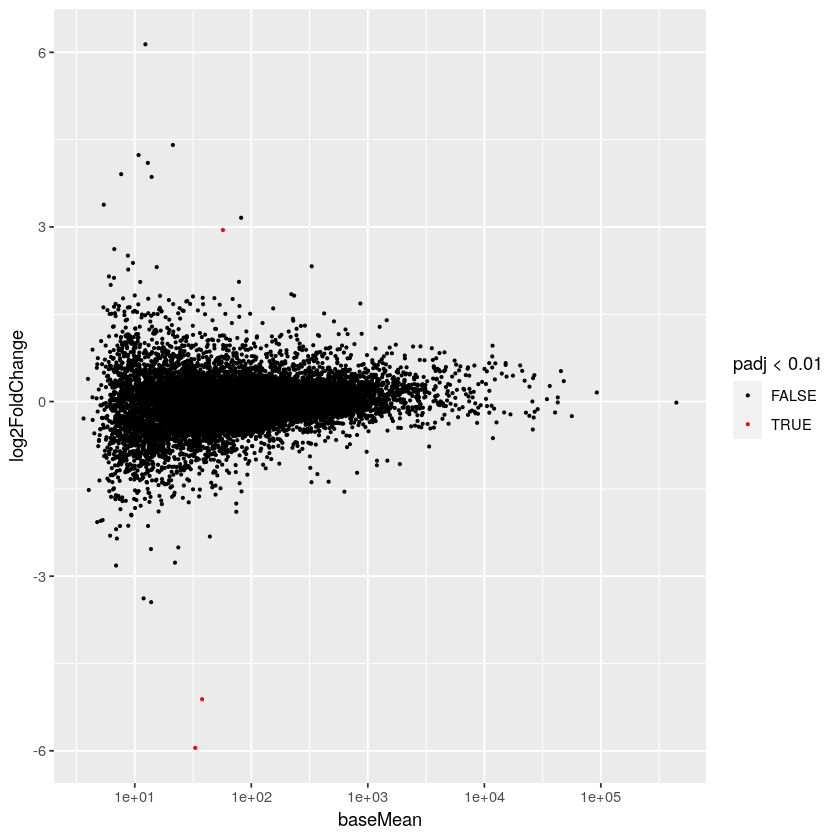

In [22]:
ggplot(as.data.frame(res), aes(x = baseMean, y = log2FoldChange)) +
    geom_point(aes(colour = padj < 0.01), size = 0.5) +
    scale_x_continuous(trans = "log10") +
    scale_color_manual(name = "padj < 0.01", values = setNames(c("red", "black"), c(T, F)))

As you can see genes with a low mean (left of the plot) have a big variance of the log2foldchange. This can also be seen by looking at the standard error of the log2foldchange vs the mean

Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”


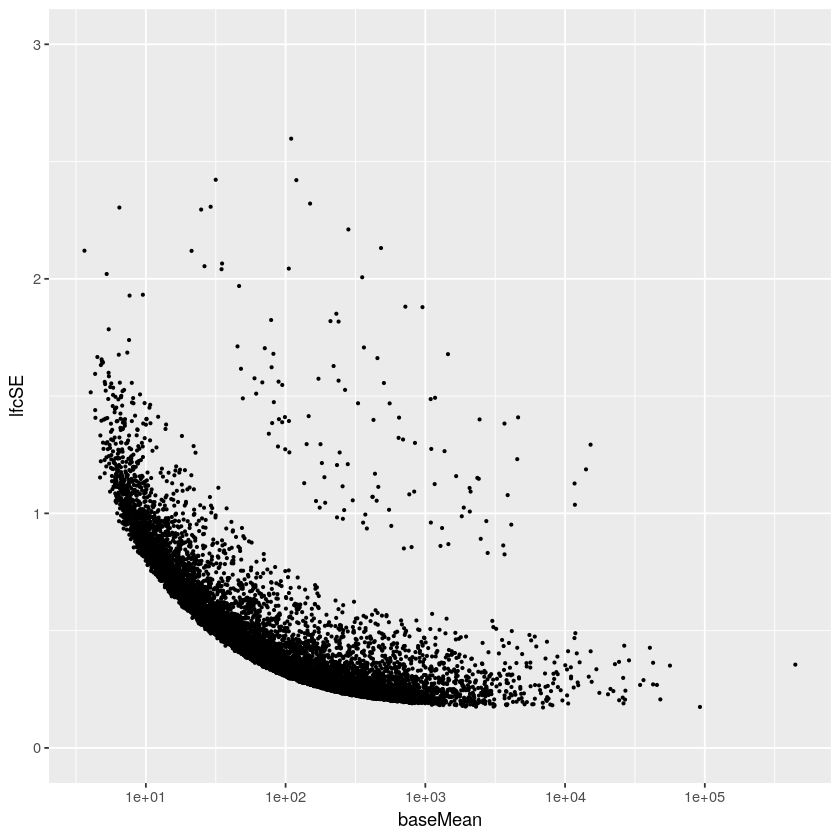

In [23]:
ggplot(as.data.frame(res), aes(x = baseMean, y = lfcSE)) +
    geom_point(size = 0.5) +
    scale_x_continuous(trans = "log10") +
    ylim(0, 3)

To account for this DESeq2 has a function to *shrink* Log2FoldChange towards zero in such a manner that the shrinkage is stronger when the available information for a gene is low (i.e. low number of counts, are dispersion is high).

The function for this is called

    lfcShrink

it takes the `dds` object as input together with the coefficient we want to shrink

In [30]:
resultsNames(dds)

[1] "Intercept"                                      
[2] "condition_control_negative_vs_control_positive" 
[3] "condition_treatment_healthy_vs_control_positive"
[4] "condition_treatment_tumor_vs_control_positive"

**Research question:** How does regular exercise suppress liver cancer development at the molecular level in mice?

**Experiment setup:** 

* Exercise group: (Treatment)
    * tumor tissue
    * non-tumor tissue
    
* Non-Exercise group: (Control)
    * tumor tissue (positive control)
    * non-tumor tissue (negative control)
    
**Comparisom of interest:** 

* Exercise (Non-Tumor) vs. Non-Exercise (Non-Tumor) --> genes affected by exercise on healthy tissue
* Exercise (Tumor) vs. Non-Exercise (Tumor) -------------> genes affected by exercise on cancer tissue
    

We want to shrink the coefficient `condition_treatment_vs_control` as this stores our Log2FoldChange values.

In [31]:
resLFC <- lfcShrink(dds, coef="condition_treatment_tumor_vs_control_positive")
#resLFC <- lfcShrink(dds, coef="condition_treatment_healthy_vs_control_negative")

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [32]:
resLFC

log2 fold change (MAP): condition treatment tumor vs control positive 
Wald test p-value: condition treatment tumor vs control positive 
DataFrame with 12353 rows and 6 columns
                baseMean      log2FoldChange             lfcSE
               <numeric>           <numeric>         <numeric>
Sox17   17.9218351322995  0.0567175928080931  0.14291740155147
Mrpl15  196.706977153318    0.17245659275457 0.159496849929938
Lypla1  663.927686987207  0.0880983772182862  0.15272993090251
Tcea1    89.189070084373 -0.0562815738874985 0.167276006318027
Atp6v1h 301.397408016249  0.0991751933429822 0.155904291214187
...                  ...                 ...               ...
mt-Nd4   17595.333834649   0.268700131733794 0.156378290318787
mt-Nd5  21122.2012989453   0.313952404080442 0.159788822397032
mt-Nd6  7239.17946086626    0.33737984146127 0.161289248212835
mt-Cytb 45442.2545225807   0.278845104816705 0.162489871414738
mt-Tp   16.2642361249761 -0.0916965214226082 0.137276043991649
    

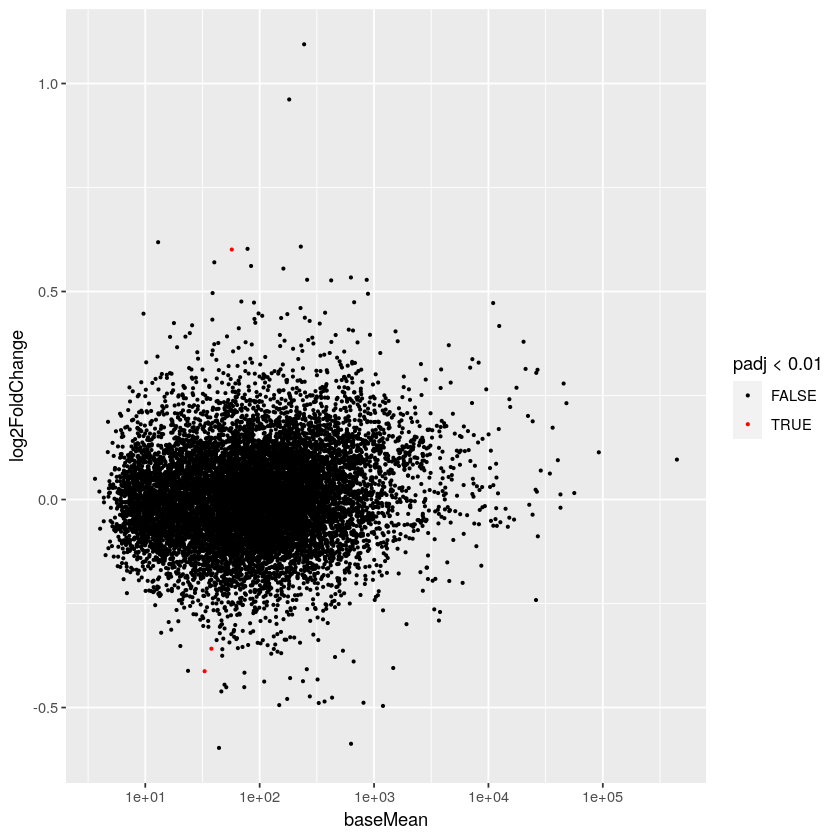

In [33]:
ggplot(as.data.frame(resLFC), aes(x = baseMean, y = log2FoldChange)) +
    geom_point(aes(colour = padj < 0.01), size = 0.5) +
    scale_x_continuous(trans = "log10") +
    scale_color_manual(name = "padj < 0.01", values = setNames(c("red", "black"), c(T, F)))

As you can see, now the effect of the mean on the variance of the Log2FoldChange is much smaller. Again we can also visualize this by plotting the standard error.

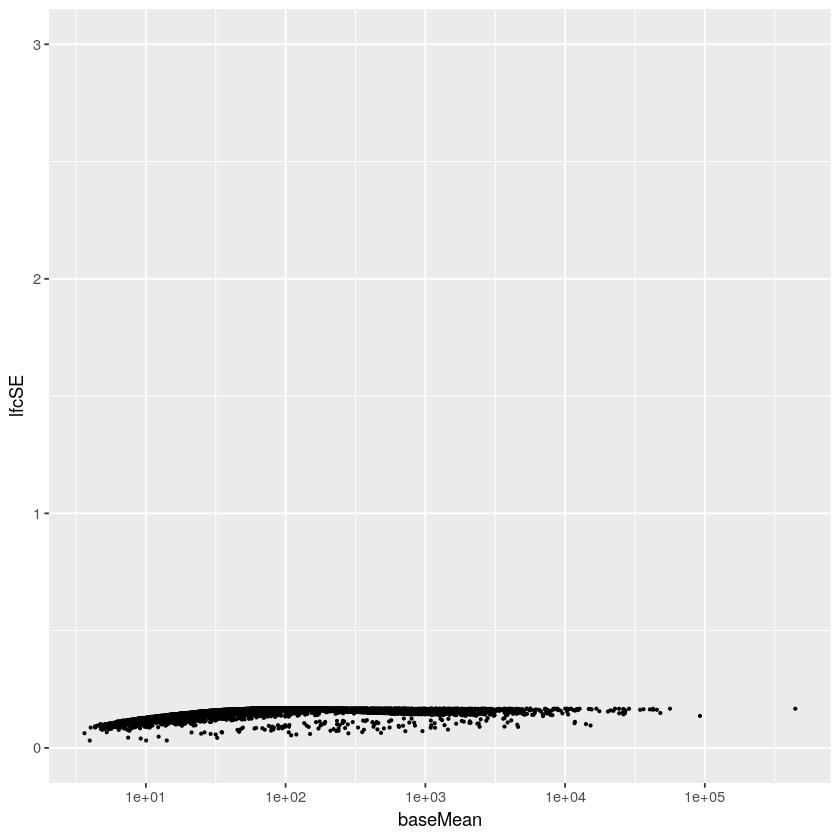

In [34]:
ggplot(as.data.frame(resLFC), aes(x = baseMean, y = lfcSE)) +
    geom_point(size = 0.5) +
    scale_x_continuous(trans = "log10") +
    ylim(0, 3)

## Step 3. Downstream analysis

### Getting a list of up- or downregulated genes
To manipulate dataframe we use the package dplyr

In [36]:
suppressWarnings(library(dplyr))

In [37]:
resLFC_df <- as.data.frame(resLFC)

Let's define some thresholds

In [38]:
log2FC_thr = 1
pad_thr = 0.01

In [39]:
upregulated_genes <- row.names(resLFC_df %>% 
    filter(log2FoldChange > log2FC_thr, padj < pad_thr))

In [40]:
downregulated_genes <- row.names(resLFC_df %>% 
    filter(log2FoldChange < log2FC_thr, padj < pad_thr))

## Sorting the gene list based on log2FC values

In [41]:
resLFC_df %>%
    arrange(log2FoldChange)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BC023105,44.11894,-0.5970187,0.1559577,-4.244207,2.193677e-05,0.067746233
Hamp,629.21777,-0.5871166,0.1589074,-3.124458,1.781328e-03,0.999847818
Mpeg1,1196.82664,-0.4961173,0.1671407,-3.291617,9.961305e-04,0.946553824
Igtp,148.31032,-0.4941455,0.1670950,-3.066033,2.169194e-03,0.999847818
H2-Ab1,328.44018,-0.4891545,0.1644675,-3.270061,1.075243e-03,0.948748622
Cd74,808.72734,-0.4884671,0.1663907,-3.165005,1.550800e-03,0.999847818
H2-Aa,369.20592,-0.4855183,0.1661439,-3.165693,1.547142e-03,0.999847818
H2-Q6,174.02096,-0.4793420,0.1670919,-3.310821,9.302270e-04,0.946553824
Pnrc1,429.74990,-0.4761762,0.1498816,-3.218267,1.289676e-03,0.999847818


In [46]:
library(dplyr)

write.table(resLFC_df, file = "resLFC_df.tsv", sep = "\t", quote = FALSE)

### Plotting a heatmap

In [43]:
library(pheatmap)

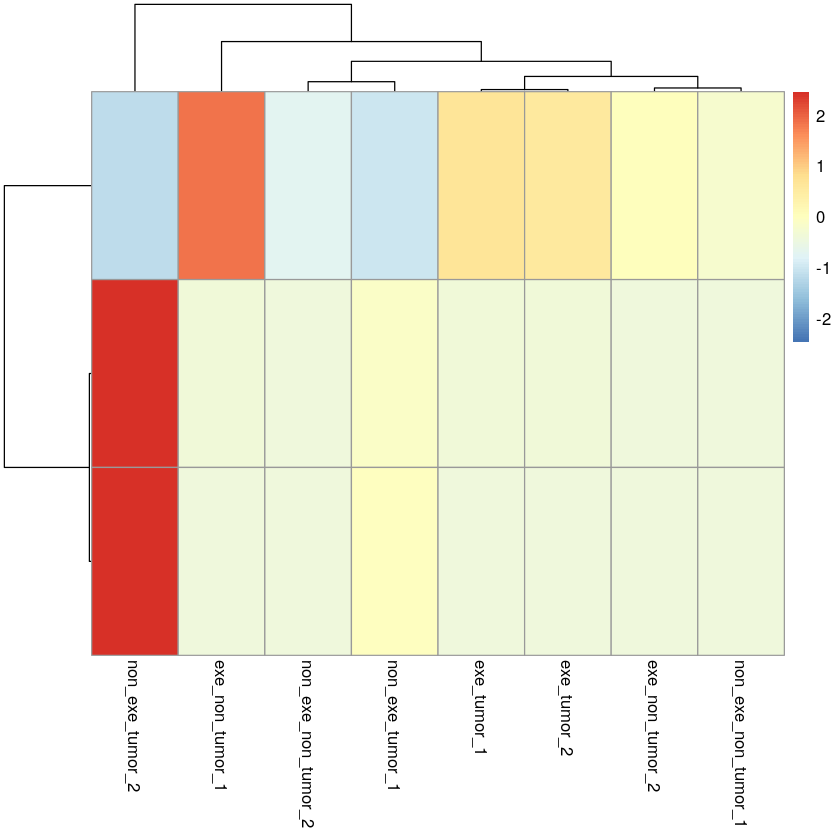

In [44]:
pheatmap(cts[c(upregulated_genes, downregulated_genes), ], scale = "row", show_rownames = F)